In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, default_collate
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import torchvision
import os
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import glob
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import glob
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
import random
from copy import deepcopy

## Plotter

In [2]:
class Plotter:

    def plot_training_val_b1(self, training_loss, val_loss, val_accuracy):
        epochs = range(1, len(training_loss) + 1)

        fig, ax1 = plt.subplots()
        ax1.plot(epochs, training_loss, 'b-', label='Training Loss')
        ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Training and Validation Loss')

        plt.figure()
        plt.plot(epochs, val_accuracy, 'g-', label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Validation Accuracy')

        plt.show()

    def plot_test_b1(self, loss, metrics, confusion_data):
        # Print metrics
        print(f"Loss: {loss:.4f}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")

        # Plot confusion matrix
        cm = confusion_matrix(confusion_data['true_labels'], confusion_data['predictions'])
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

plotter = Plotter()

## Data Processing

In [3]:
class DataProcessorBaselineTwo():

    def __init__(self, videos_root, map_classes=True):
        self.frame_mapping = {'l-spike': 0, 'l_set': 1, 'r_set': 2, 'r-pass': 3, 'r_spike': 4, 'l-pass': 5,
                              'r_winpoint': 6, 'l_winpoint': 7}
        self.player_mapping = {
            'waiting': 0, 'setting': 1, 'digging': 2, 'falling': 3, 'spiking': 4,
            'blocking': 5, 'jumping': 6, 'moving': 7, 'standing': 8}
        self.map_classes = map_classes
        self.root = videos_root

        self.dataset = self.collect_video_data()


    def get_dataset(self):
        return self.dataset

    def __process_players(self, line):
        words = line.split()
        boxes = []  # List to store (box, class) tuples

        # Skip frame ID and extra info (assuming it's always at index 1)
        words = words[2:]

        # Iterate through bounding box annotations
        for i in range(0, len(words), 5):
            x1, y1, x2, y2 = map(int, words[i:i + 4])  # Extract coordinates

            class_name = words[i + 4]  # Extract class name
            class_id = self.player_mapping[class_name]

            boxes.append(((x1, y1, x2, y2), class_id))

        return boxes

    def collect_video_data(self):
        dataset = []  # List to store video data
        videos = np.arange(55)
        for video in videos:
            video_path = os.path.join(self.root, str(video))
            annotation_path = os.path.join(video_path, 'annotations.txt')
            data_from_annotation = self.__parse_annotation(annotation_path, video_path, video)
            dataset.extend(data_from_annotation)
        return dataset

    def __parse_annotation(self, annotation, video_path, video_id):
        output = []
        with open(annotation, 'r') as f:
            for line in f:
                parts = line.strip().split()
                # Extract the frame ID (image name) and frame activity class
                frame_image = parts[0]  # Image name (e.g., '48075.jpg')
                frame_activity_class = parts[1]  # Frame Activity Class (e.g., 'r_winpoint')

                # Remove .jpg from frame_image to get the frame ID
                frame_id = os.path.splitext(frame_image)[0]

                # Construct the expected path to the target image
                target_image_path = os.path.join(video_path, str(frame_id), frame_image)

                # get players in frame
                players = self.__process_players(line)
                if os.path.exists(target_image_path):
                    output.append(
                        {
                            'video': video_id,
                            'frame': target_image_path,
                            'class': frame_activity_class,
                            'mapped_class': self.frame_mapping[frame_activity_class],
                            'players': players
                        }
                    )
                else:
                    print(f"Target image not found: {target_image_path}")
        return output

Make sure you want to run this before running it

In [4]:
!rm -rf '/kaggle/working/'

rm: cannot remove '/kaggle/working/': Device or resource busy


In [5]:
base_path = '/kaggle/input/volleyball/volleyball_/videos/'
df = DataProcessorBaselineTwo(base_path).get_dataset()

## Model

In [6]:
class ResnetEvolution(nn.Module):
    def __init__(self):
        super(ResnetEvolution, self).__init__()
        self.model = self.__init_backbone(torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2, progress=False))

    def __init_backbone(self, backbone):
        num_features = backbone.fc.in_features
        layers = nn.Sequential(
            nn.Linear(num_features, 9),
        )
        backbone.fc = layers
        return backbone

    def get_fc(self):
        return self.model.fc

    def forward(self, images):
        return self.model(images)

## Training Utils

In [7]:
class TrainingUtilities:
    @staticmethod
    def save_model(model, model_descriptor, save_folder, verbose=0):
        torch.save(model.state_dict(), save_folder + f"/{model_descriptor}b1_model.pth")
        if verbose > 0:
            print(f"Saved model to {save_folder}/b1_model.pth")

    @staticmethod
    def save_checkpoint(epoch, model_state_dict, optimizer_state_dict, scheduler_state_dict=None, save_folder='', verbose=0):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'scheduler_state_dict': scheduler_state_dict
        }
        torch.save(checkpoint, save_folder + f'/checkpoint-epoch{epoch}.pth')
        if verbose > 0:
            print(f'Saved checkpoint to {save_folder}/checkpoint-epoch{epoch}.pth')

    @staticmethod
    def load_checkpoint(model, optimizer, checkpoint_path, scheduled, verbose=0):
        checkpoint = torch.load(checkpoint_path)

        if verbose > 0:
            print(f"Loading checkpoint from {checkpoint_path}")

        epoch = checkpoint['epoch']
        model_state_dict = checkpoint['model_state_dict']
        optimizer_state_dict = checkpoint['optimizer_state_dict']
        scheduler_state_dict = checkpoint['scheduler_state_dict']
        model = model.load_state_dict(model_state_dict)
        if scheduled:
            optimizer.load_state_dict(optimizer_state_dict, scheduler_state_dict)
        else:
            optimizer = optimizer.load_state_dict(optimizer_state_dict)
        return epoch, model, optimizer

## Trainer

In [8]:
class b1_ModelTrainer:
    def __init__(self, model, optimizer, scheduled, criterion, epochs, dataloaders, device, save_folder,
                 is_continue=False, checkpoint=None):
        self.model = model
        self.optimizer = optimizer
        self.scheduled = scheduled
        self.criterion = criterion
        self.epochs = epochs
        self.dataloaders = dataloaders
        self.DEVICE = device
        self.save_folder = save_folder
        self.is_continue = is_continue
        self.checkpoint = checkpoint
        self.scaler = torch.amp.GradScaler()

    # verbose 1 : checkpoint,
    # verbose 3:  labels, preds
    # verbose 4: logits
    def train_model(self, verbose=0):
        model, optimizer, criterion, epochs, dataloaders, scaler = self.model, self.optimizer, self.criterion, self.epochs, self.dataloaders, self.scaler
        best_model = model
        best_acc = 0.0
        epoch = 0

        train_losses = []
        val_losses = []
        val_accuracies = []

        if self.is_continue:

            if verbose > 0:
                print(f"Continuing from checkpoint {self.checkpoint}")

            epoch, model, optimizer = self.__load_checkpoint(model, optimizer, self.checkpoint, verbose)

        for training_epoch in range(epoch, epochs):

            print(f"\nTraining epoch {training_epoch+1}")

            ## change model mode depending on the phase
            for phase in ['train', 'val']:
                dataloader = dataloaders[phase]
                epoch_loss = 0  # Track total loss for the epoch
                if phase == 'train':
                    if verbose > 0:
                        dataloader = tqdm(dataloader, desc=phase)
                    model.train()
                    for inputs, labels in dataloader:

                        inputs = inputs.to(self.DEVICE)
                        labels = labels.to(self.DEVICE)

                        if verbose > 3:
                            print(f"labels: {labels}")

                        # zero grads of he optim
                        optimizer.zero_grad()

                        # freeze the non-learnable weights
                        # self.__handle_transfer_learning(phase, training_epoch / epochs)

                        with torch.amp.autocast('cuda'):
                            # forward pass
                            logit = model(inputs)

                            if verbose > 3:
                                print(f"logit: {logit}")

                            loss = criterion(logit, labels)

                        scaler.scale(loss).backward()
                        optimizer.step(scaler)
                        scaler.update()

                        epoch_loss += loss.item()  # Accumulate loss

                    train_losses.append(epoch_loss / len(dataloader))
                    print(
                        f"Epoch {training_epoch + 1}/{epochs}, {phase} Loss: {epoch_loss / len(dataloader)}")  # Print loss
                else:
                    # skip evaluation if no suitable dataloader
                    if dataloaders[phase] is None:
                        continue
                    model.eval()
                    loss, acc = self.__eval_model(dataloader, verbose)
                    if acc > best_acc:
                        best_acc = acc
                        best_model = deepcopy(model)
                    val_losses.append(loss)
                    val_accuracies.append(acc)
                    print(
                        f"Epoch {training_epoch + 1}/{epochs}, ({phase}) Loss: {loss} | Accuracy: {acc}")  # Print loss

            if self.scheduled:
                optimizer.scheduler_step()
                if training_epoch % 10 == 0:
                    TrainingUtilities.save_checkpoint(training_epoch, model.state_dict(), optimizer.optimizer_state_dict(),
                                           optimizer.scheduler_state_dict(), self.save_folder, verbose)
            else:
                if training_epoch % 10 == 0:
                    TrainingUtilities.save_checkpoint(training_epoch, model.state_dict(), optimizer.state_dict(),self.save_folder, verbose)

            if training_epoch % 10 == 0:
                TrainingUtilities.save_model(model, training_epoch, self.save_folder,verbose)

        TrainingUtilities.save_model(best_model, 'final_', self.save_folder, verbose)
        return train_losses, val_losses, val_accuracies, best_model

    def __handle_transfer_learning(self, phase, ratio_epochs, tl_coeff=0, verbose=0):
        if phase == "train":
            if self.__check_transfer_learning(ratio_epochs, tl_coeff):
                # Unfreeze all layers for fine-tuning
                for param in self.model.parameters():
                    param.requires_grad = True
            else:
                # Freeze the CNN part
                for param in self.model.parameters():
                    param.requires_grad = False
                # Unfreeze the classification layer
                for param in self.model.get_fc().parameters():
                    param.requires_grad = True
        elif phase == "val":
            for param in self.model.parameters():
                param.requires_grad = False

    def __check_transfer_learning(self, ratio_epochs, tl_coeff=0):
        return ratio_epochs >= tl_coeff

    def __eval_model(self, dataloader, verbose=0):
        model = self.model
        criterion = self.criterion
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0
        if verbose > 0:
            dataloader = tqdm(dataloader, desc="Validation")
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                for inputs, labels in dataloader:
                    inputs = inputs.to(self.DEVICE)
                    labels = labels.to(self.DEVICE)

                    if verbose > 2:
                        print(f"labels: {labels}")

                    # Forward pass
                    logits = model(inputs)

                    if verbose > 3:
                        print(f"logit: {logits}")

                    probs = F.softmax(logits, dim=1)  # Apply softmax to get probabilities

                    if verbose > 3:
                        print(f"probs: {probs}")

                    loss = criterion(logits, labels)
                    val_loss += loss.item()  # Accumulate loss

                    # Compute accuracy
                    predicted = torch.argmax(probs, dim=1)  # Get the class with the highest probability

                    if verbose > 2:
                        print(f"predicted: {predicted}")
                        print(f"true/false: {(predicted == labels)}")

                    correct_preds += (predicted == labels).sum().item()
                    total_preds += labels.size(0)

        # Calculate average loss and accuracy
        avg_loss = val_loss / len(dataloader)
        accuracy = correct_preds / total_preds
        return avg_loss, accuracy

## Dataset

In [9]:
class PlayerDataset(Dataset):
    def __init__(self, dataset, split='train', transform=None, downsampled_class=8, downsample_ratio=0.15, downsample=True):
        self.dataset = dataset
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transform

        VIDEO_SPLITS = {
            'train': [1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54],
            'val': [0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51],
            'test': [4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47]
        }

        self.index_map = []
        list_split = VIDEO_SPLITS[split]
        self.labels = []

        downsampled_class_index_map = []
        for item_idx, item in enumerate(self.dataset):
            if int(item['video']) in list_split:
                for player_idx, (bbox, action_class) in enumerate(item['players']):
                    if action_class != downsampled_class:
                        self.index_map.append((item_idx, player_idx))
                        self.labels.append(action_class)
                    else:
                        downsampled_class_index_map.append((item_idx, player_idx))

        downsample_size = int(len(downsampled_class_index_map) * downsample_ratio)
        if downsample:
            downsampled_class_index_map = random.sample(downsampled_class_index_map, downsample_size)

        self.index_map.extend(downsampled_class_index_map)
        self.labels.extend([downsampled_class] * len(downsampled_class_index_map))

        print(f'the {split} has {len(self.index_map)} samples')
        self.invalid = 0

    def get_labels(self):
        return self.labels

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        item_idx, player_idx = self.index_map[idx]
        item = self.dataset[item_idx]
        frame_path = item['frame']
        bbox, action_class = item['players'][player_idx]

        image = Image.open(frame_path).convert('RGB')
        x1, y1, w, h = bbox
        x2 = x1 + w
        y2 = y1 + h
        bbox = (x1, y1, x2, y2)

        if bbox[2] <= bbox[0] or bbox[3] <= bbox[1]:
            self.invalid += 1
            print(f'invalids:{self.invalid}')
            return torch.rand(3, 224, 244), torch.tensor(action_class, dtype=torch.long)

        cropped_image = image.crop(bbox)  # (x1, y1, x2, y2)

        cropped_image = self.transform(cropped_image)

        return cropped_image, torch.tensor(action_class, dtype=torch.long)

## Loss

In [10]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, dataset, device, num_classes=8):
        super().__init__()
        self.device = device
        self.num_classes = num_classes
        self.weights = self.__compute_weights(dataset).to(device)
        self.loss = nn.CrossEntropyLoss(weight=self.weights)

    def __compute_weights(self, dataset):
        labels = torch.tensor(dataset.get_labels(), dtype=torch.long)
        class_counts = torch.bincount(labels, minlength=self.num_classes)
        total_samples = len(labels)
        weights = total_samples / (class_counts + 1e-6)  # Avoid div by zero
        return weights.float()

    def forward(self, logit, target):
        return self.loss(logit, target)

In [11]:
class AugmentationCELoss(WeightedCrossEntropyLoss):
    def __init__(self, dataset, device, num_classes):
        super().__init__(dataset, device, num_classes)

    def forward(self, logit, target):
        return F.cross_entropy(logit, target, weight=self.weights)

## Optimizer

In [12]:
class AdamWScheduled():
    def __init__(self, model_params, lr, step_size, gamma):
        self.optimizer = optim.AdamW(model_params,  lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size, gamma)

    def step(self, scaler):
        scaler.step(self.optimizer)

    def zero_grad(self):
        self.optimizer.zero_grad()

    def scheduler_step(self):
        self.scheduler.step()

    def optimizer_state_dict(self):
        return self.optimizer.state_dict()

    def scheduler_state_dict(self):
        return self.scheduler.state_dict()

    def load_state_dict(self, optimizer_state_dict, scheduler_state_dict):
        self.optimizer.load_state_dict(optimizer_state_dict)
        self.scheduler.load_state_dict(scheduler_state_dict)

## Custom dataloader

In [13]:
class AugmentationDataLoader():
    def __init__(self, dataset, batch_size, shuffle, num_workers, pin_memory, num_classes, mixup_alpha=1.0, cutmix_alpha=1.0):
        mixup_alpha = float(mixup_alpha)
        cutmix_alpha = float(cutmix_alpha)

        cutmix = v2.CutMix(num_classes=num_classes, alpha=cutmix_alpha)
        mixup = v2.MixUp(num_classes=num_classes, alpha=mixup_alpha)
        self.cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
        self.loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=shuffle, collate_fn=self.collate_fn)

    def get_loader(self):
        return self.loader

    def collate_fn(self, batch):
        inputs, labels = default_collate(batch)
        return self.cutmix_or_mixup(inputs, labels)

## Dataloaders and Transforms

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
train_dataset = PlayerDataset(df, split='train', downsample_ratio=0.05)
val_dataset = PlayerDataset(df, split='val', downsample_ratio=0.05)
test_dataset_downsampled = PlayerDataset(df, split='test', downsample_ratio=0.05)
test_dataset = PlayerDataset(df, split='test', downsample=False)

the train has 8754 samples
the val has 5416 samples
the test has 5403 samples
the test has 15526 samples


In [16]:
batch_size = 150
train_loader = AugmentationDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, num_classes=9, mixup_alpha=0.9, cutmix_alpha=0.9).get_loader()
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader_ds = DataLoader(test_dataset_downsampled, batch_size=batch_size, shuffle=False, num_workers=4)
dataloaders = {'train': train_loader, 'val': val_loader}

## Custom Criterion

In [17]:
# criterion = WeightedCrossEntropyLoss(train_dataset, device, num_classes=9)
criterion = AugmentationCELoss(dataset=train_dataset, device=device, num_classes=9)

## Model Training

In [18]:
model = ResnetEvolution().to(device)
optimizer = AdamWScheduled(model_params=model.parameters(), lr=0.001, step_size=10, gamma=0.1)

save_folder = '/kaggle/working/'
trainer = b1_ModelTrainer(model, optimizer,True, criterion, epochs=30, dataloaders=dataloaders, device=device, save_folder=save_folder)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


In [19]:
train_losses, val_losses, val_accuracies, best_model = trainer.train_model(verbose=0)


Training epoch 1
Epoch 1/30, train Loss: 16.125758268065372
Epoch 1/30, (val) Loss: 1.541759822819684 | Accuracy: 0.4492245199409158

Training epoch 2
Epoch 2/30, train Loss: 13.984549587055788
Epoch 2/30, (val) Loss: 1.2947850436777681 | Accuracy: 0.5657311669128509

Training epoch 3
Epoch 3/30, train Loss: 12.687742087800624
Epoch 3/30, (val) Loss: 1.5569886065818168 | Accuracy: 0.4950147710487445

Training epoch 4
Epoch 4/30, train Loss: 11.758934934260482
Epoch 4/30, (val) Loss: 1.3196050750242698 | Accuracy: 0.5251107828655834

Training epoch 5
Epoch 5/30, train Loss: 11.44663749306889
Epoch 5/30, (val) Loss: 1.1588006245123375 | Accuracy: 0.5588995568685377

Training epoch 6
Epoch 6/30, train Loss: 10.524385161319021
Epoch 6/30, (val) Loss: 1.2074752530536137 | Accuracy: 0.6286927621861153

Training epoch 7
Epoch 7/30, train Loss: 9.956616825976614
Epoch 7/30, (val) Loss: 1.2468237989657633 | Accuracy: 0.604135893648449

Training epoch 8
Epoch 8/30, train Loss: 10.01424691636683

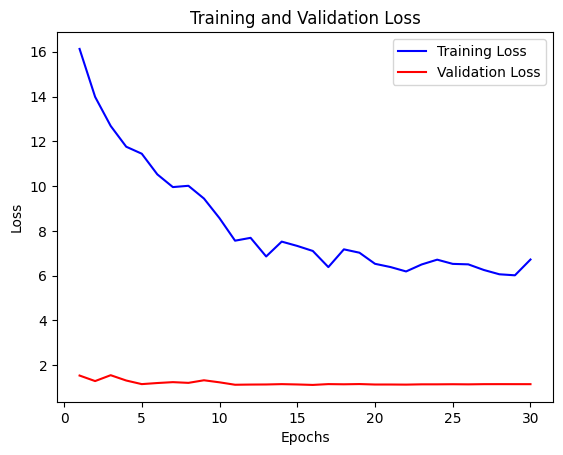

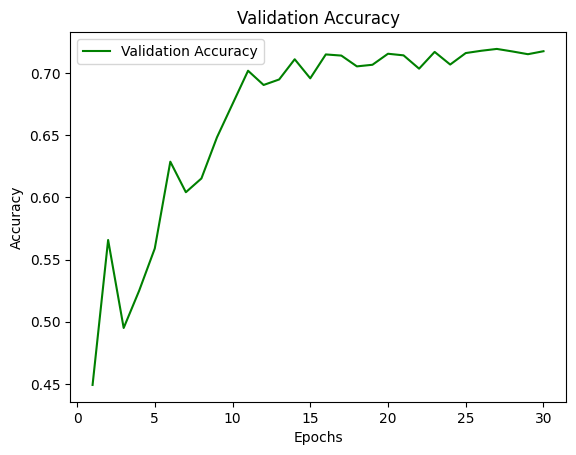

In [20]:
plotter.plot_training_val_b1(train_losses, val_losses, val_accuracies)

## Model Evaluation

In [21]:
class b1_ModelTester():
    def __init__(self, model, criterion, dataloader, device):
        self.model = model
        self.criterion = criterion
        self.dataloader = dataloader
        self.DEVICE = device

    def evaluate(self, verbose=0):
        dataloader = self.dataloader
        model = self.model
        criterion = self.criterion
        model.eval()

        # Initialize metrics tracking
        val_loss = 0
        all_labels = []
        all_predictions = []
        all_probabilities = []

        if verbose > 0:
            dataloader = tqdm(dataloader, desc="Testing")

        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                for inputs, labels in dataloader:
                    inputs = inputs.to(self.DEVICE, non_blocking=True)
                    labels = labels.to(self.DEVICE, non_blocking=True)

                    if verbose > 2:
                        print(f"labels: {labels}")

                    # Forward pass
                    logits = model(inputs)
                    probs = F.softmax(logits, dim=1)

                    if verbose > 3:
                        print(f"logits: {logits}")
                        print(f"probs: {probs}")

                    # Calculate loss
                    loss = criterion(logits, labels)
                    val_loss += loss.item()

                    # Get predictions
                    predicted = torch.argmax(probs, dim=1)

                    if verbose > 2:
                        print(f"predicted: {predicted}")
                        print(f"true/false: {(predicted == labels)}")

                    # Store predictions and labels for later metric calculation
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy())
                    all_probabilities.extend(probs.cpu().numpy())

        # Calculate average loss
        avg_loss = val_loss / len(dataloader)

        # Convert lists to numpy arrays for easier manipulation
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        all_probabilities = np.array(all_probabilities)

        # Calculate metrics for each class
        num_classes = all_probabilities.shape[1]
        metrics_dict = {
            'accuracy': accuracy_score(all_labels, all_predictions),
            'precision': precision_score(all_labels, all_predictions, average='macro', zero_division=0),
            'recall': recall_score(all_labels, all_predictions, average='macro', zero_division=0),
            'f1': f1_score(all_labels, all_predictions, average='macro', zero_division=0),
            'per_class': {
                'precision': precision_score(all_labels, all_predictions, average=None, zero_division=0),
                'recall': recall_score(all_labels, all_predictions, average=None, zero_division=0),
                'f1': f1_score(all_labels, all_predictions, average=None, zero_division=0)
            }
        }

        # Prepare confusion matrix data
        confusion_data = {
            'true_labels': all_labels,
            'predictions': all_predictions,
            'probabilities': all_probabilities,
            'num_classes': num_classes
        }

        return avg_loss, metrics_dict, confusion_data

In [22]:
tester = b1_ModelTester(best_model, criterion, test_loader, device)
tester_ds = b1_ModelTester(best_model, criterion, test_loader_ds, device)

In [23]:
loss, metrics, confusion_data = tester.evaluate(verbose=0)

Loss: 1.3136
Accuracy: 0.5663
Precision: 0.4986
Recall: 0.6911
F1 Score: 0.5456


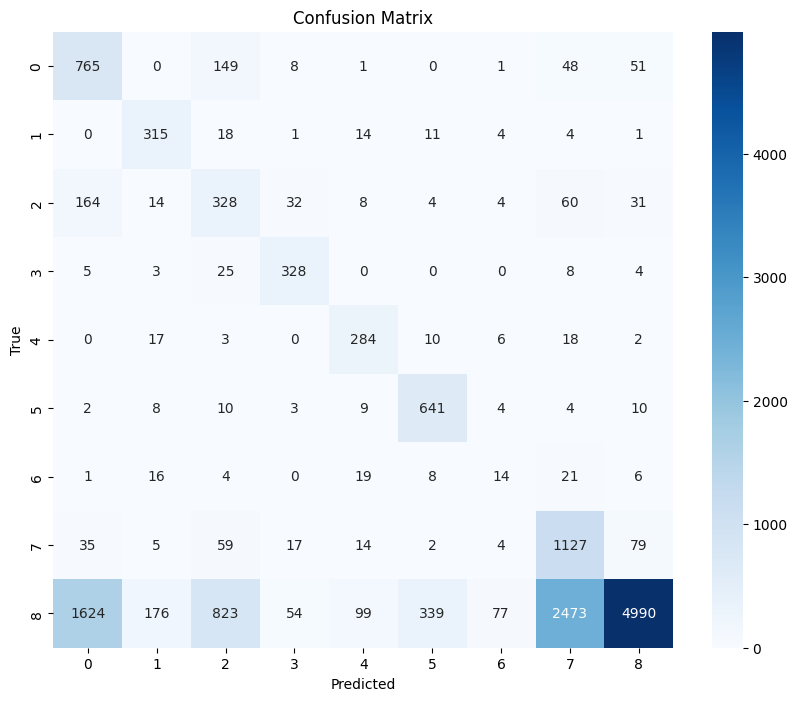

In [24]:
plotter.plot_test_b1(loss, metrics, confusion_data)

In [25]:
loss, metrics, confusion_data = tester_ds.evaluate(verbose=0)

Loss: 0.9898
Accuracy: 0.7496
Precision: 0.7047
Recall: 0.6909
F1 Score: 0.6935


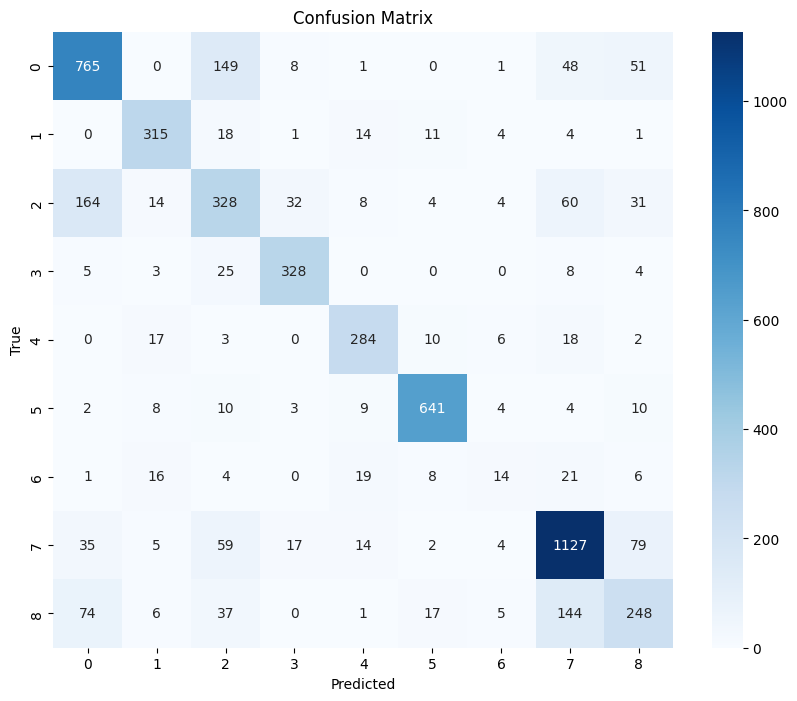

In [26]:
plotter.plot_test_b1(loss, metrics, confusion_data)